In [90]:
import numpy as np
from sklearn import datasets
from matplotlib.colors import ListedColormap
import matplotlib.pylab as plt

In [91]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

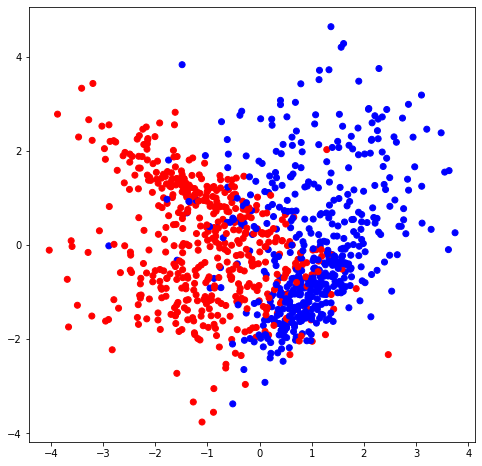

In [92]:
# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=1000, 
                                       n_features=2, 
                                       n_informative=2,
                                       n_redundant=0, 
                                       n_classes=2, 
                                       random_state=1)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

In [93]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (700, 2)
Размер массива признаков тестовой выборки (300, 2)
Размер массива ответов для обучающей выборки (700,)
Размер массива ответов для тестовой выборки (300,)


In [94]:
X_train_tr = X_train.transpose()
y_train_tr = y_train.reshape(1, y_train.shape[0])
X_test_tr = X_test.transpose()
y_test_tr = y_test.reshape(1, y_test.shape[0])

### Задание 1.
Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.

In [110]:
def log_loss(w, X, y):
    m = X.shape[1]

    # используем функцию сигмоиды, написанную ранее
    A = sigmoid(np.dot(w, X))
    res1 = y * np.log(A)
    res1 = 0 if np.isinf(res1) else res1
    res0 = (1 - y) * np.log(1 - A)
    res0 = 0 if np.isinf(res0) else res0
    loss = -1.0 / m * np.sum(res1 + res0)
    if np.isinf(loss):
        loss = 1e+8
    loss = np.squeeze(loss)
    return loss

### Задание 2.
Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

In [102]:
def eval_model(X, y, max_iterations: int, min_dist=1e-6, alpha=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    m = X.shape[1]
    dist = np.inf
    iter_ = 1
    while (dist >= min_dist) and (iter_ <= max_iterations):
        loss = log_loss(W, X, y)
        y_pred = sigmoid(np.dot(W, X))
        grad = 1.0 / m * np.dot((y_pred - y), X.T)
        grad = grad.reshape(W.shape)
        delta = alpha * grad
        W -= delta
        dist = np.linalg.norm(delta, ord=2)
        if iter_ % (max_iterations / 10) == 0:
            print(iter_, W, loss, dist)
        iter_ += 1
    return W

W = eval_model(X_train_tr, y_train_tr, 500000)

50000 [1.25128558 0.01845851] 0.37359754283608254 8.848117740953376e-06
100000 [1.56718269 0.07779487] 0.3522429752359982 4.703909919957002e-06
150000 [1.74960385 0.11329358] 0.34520632001929924 2.9314664332655646e-06
200000 [1.86750981 0.13732178] 0.34227200736005375 1.9670968138091803e-06
250000 [1.94820607 0.1543869 ] 0.34089689345736296 1.37609186497953e-06


### Задание 3
Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

In [103]:
def calc_pred_proba(x, w):
    return sigmoid(np.dot(w, x))

y_pred_proba = calc_pred_proba(X_train_tr, W)

### Задание 4.
Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).

In [104]:
def calc_pred(x, w):
    y_pred_proba = calc_pred_proba(x, w)
    y_pred = y_pred_proba >= 0.5
    return y_pred.astype(int)

y_pred_train = calc_pred(X_train_tr, W)
y_pred_test = calc_pred(X_test_tr, W)

### Задание 5.
Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

In [105]:
def accuracy(y_pred, y):
    eq = np.equal(y_pred, y)
    return np.count_nonzero(eq) / y_pred.shape[0]

accuracy(y_pred_train, y_train), accuracy(y_pred_test, y_test) 

(0.8557142857142858, 0.84)

In [107]:
def get_matrix(y_pred, y):
    tp = tn = fp = fn = 0
    for i in range(y_pred_train.shape[0]):
        if y_pred[i] == y_train[i] == 1:
            tp += 1
        elif y_pred[i] == y_train[i] == 0:
            tn += 1
        elif y_pred[i] == 1:
            fp += 1
        else:
            fn +=1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * precision * recall / (precision + recall)
    return tp, tn, fp, fn, precision, recall, f_score

tp, tn, fp, fn, precision, recall, f_score = get_matrix(y_pred_train, y_train)
tp, tn, fp, fn, precision, recall, f_score

(319, 280, 57, 44, 0.848404255319149, 0.8787878787878788, 0.8633288227334236)

###  Задание 6
Могла ли модель переобучиться? Почему?

Могла. Коэффициенты растут приближая разделяющую плоскость к тренировочным 

### Задание 7
Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

In [111]:
def eval_model_r1(X, y, max_iterations: int, 
                  min_dist=1e-6, alpha=1e-4, lambda_=1e-3):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    m = X.shape[1]
    dist = np.inf
    iter_ = 1
    while (dist >= min_dist) and (iter_ <= max_iterations):
        loss = log_loss(W, X, y)
        y_pred = sigmoid(np.dot(W, X))
        grad = 1.0 / m * np.dot((y_pred - y), X.T) + lambda_ * np.sign(W)
        grad = grad.reshape(W.shape)
        delta = alpha * grad
        W -= delta
        dist = np.linalg.norm(delta, ord=2)
        if iter_ % (max_iterations / 10) == 0:
            print(iter_, W, loss, dist)
        iter_ += 1
    return W

W = eval_model_r1(X_train_tr, y_train_tr, 500000)

50000 [1.24815681 0.01904024] 0.3738609324210061 8.778055683036633e-06
100000 [1.56166614 0.07471726] 0.3525273120890337 4.650544620191578e-06
150000 [1.74189772 0.10861311] 0.3454587506224577 2.8862868357072043e-06
200000 [1.85785979 0.13167807] 0.342485906899272 1.928255974977636e-06
250000 [1.93685679 0.14805926] 0.3410745259299013 1.3426751203370234e-06


In [114]:
def eval_model_r2(X, y, max_iterations: int, 
                  min_dist=1e-6, alpha=1e-4, lambda_=1e-3):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    m = X.shape[1]
    dist = np.inf
    iter_ = 1
    while (dist >= min_dist) and (iter_ <= max_iterations):
        loss = log_loss(W, X, y)
        y_pred = sigmoid(np.dot(W, X))
        grad = 1.0 / m * np.dot((y_pred - y), X.T) + lambda_ * W
        grad = grad.reshape(W.shape)
        delta = alpha * grad
        W -= delta
        dist = np.linalg.norm(delta, ord=2)
        if iter_ % (max_iterations / 10) == 0:
            print(iter_, W, loss, dist)
        iter_ += 1
    return W

W = eval_model_r2(X_train_tr, y_train_tr, 500000)

50000 [1.24806992 0.0184449 ] 0.37387819477438466 8.774291681062224e-06
100000 [1.56011409 0.07725265] 0.3525770904757793 4.6242719977028475e-06
150000 [1.73863714 0.1120736 ] 0.34553389276073515 2.8536750165973538e-06
200000 [1.85284332 0.13538678] 0.34257055236800915 1.8945348872531687e-06
250000 [1.93014719 0.15175456] 0.3411590606858002 1.3102770220508479e-06
